# Intoduction

This notebook represents my first participation to a Kaggle competition.

My goal is following:
1. Explore the data to gain insights
2. Feature engineering based on the insights
3. Data cleaning and preprocessing
4. Training Machine Learning methods
5. Make the predicition

# Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
123

# Data description

In [3]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

Data shape

In [4]:
print(f'Shape of train data: {train.shape[0]} rows and {train.shape[1]} columns')
print(f'Shape of test data: {test.shape[0]} rows and {test.shape[1]} columns') 
train.head()

Shape of train data: 8693 rows and 14 columns
Shape of test data: 4277 rows and 13 columns


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Feature descriptions:

- PassengerId : A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet : The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep : Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin : The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination : The planet the passenger will be debarking to.
- Age : The age of the passenger.
- VIP : Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck : Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name : The first and last names of the passenger.

- Transported : Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# EDA

## Target distribution
Explore the target to see whether under/over-sampling is needed

Text(0.5, 1.0, 'Target Distribution')

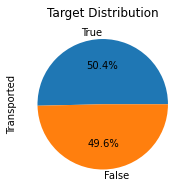

In [5]:
# set the figure size
plt.figure(figsize = (3,3))


# since our target, 'Transported', is categorical, using pie chart to show the percentage of each type
train.Transported.value_counts().plot.pie(autopct = '%1.1f%%').set_title('Target Distribution')

The target is balanced, so we dont need the under/over-sampling.

## Continuous features

In [6]:
# list feature types
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [7]:
# get the continuous features
train.select_dtypes('float64').columns

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')

### Age

Visualize the 'Age' distribution togerther with 'Transported' to get insights

Text(0.5, 1.0, 'Age distribution')

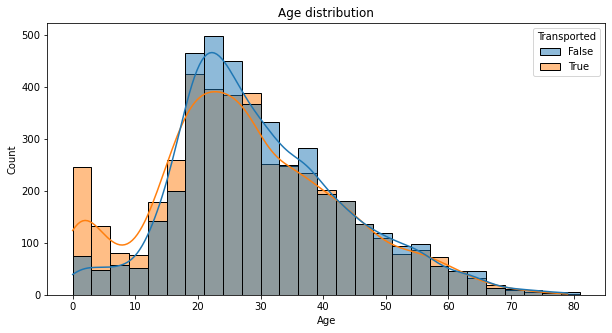

In [8]:
# set the figure size
plt.figure(figsize = (10,5))

sns.histplot(data = train, x = 'Age', hue = 'Transported', binwidth=3, kde=True)

plt.title('Age distribution')

The KDE plot shows the probability of getting transported or not at each age.

So we can find:
- 0~18 years old have **higher** chance to be transported.
- 18~40 years old have **lower** chance to be transported.
- over 40 years old are **equal** like to be transported.

Insights:
- create a new feature represents the category of age by 0~18, 18~40, >40

### Expenditure features

In [9]:
expenditure_features = train.select_dtypes('float64').columns.drop('Age')

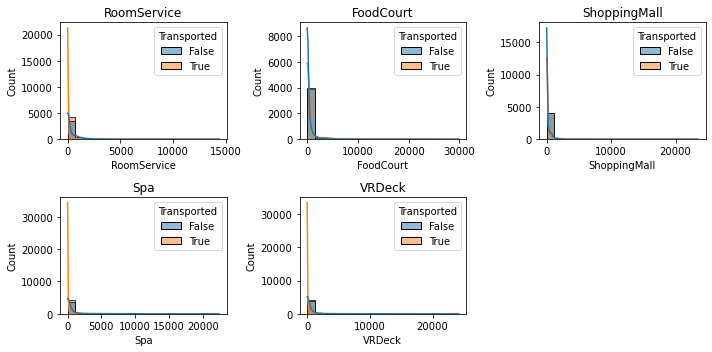

In [10]:
# visualize the expenditure features with hitogram and show them at once

fig = plt.figure(figsize=(10,5))

for idx, val in enumerate(expenditure_features):
    ax = fig.add_subplot(2,3,idx+1)
    sns.histplot(data=train, x=val, axes=ax, bins=20 ,hue='Transported', kde=True)
    ax.set_title(val)
    
plt.tight_layout()  
plt.show()

Since the data is uneven(most of passenger don't spend money), let's limit the y axis to make it more clear.

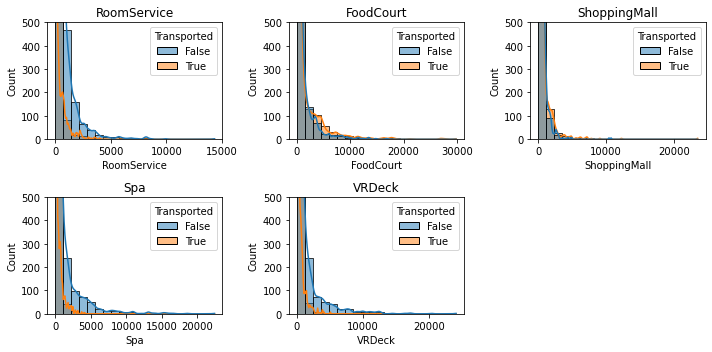

In [11]:
# visualize the expenditure features with hitogram and show them at once

fig = plt.figure(figsize=(10,5))

for idx, val in enumerate(expenditure_features):
    ax = fig.add_subplot(2,3,idx+1)
    sns.histplot(data=train, x=val, axes=ax, bins=20 ,hue='Transported', kde=True)
    ax.set_title(val)
    
    plt.ylim([0,500])
    
plt.tight_layout()  
plt.show()

We can find:
- Most passengers don't spend money
- There are smaller number of outliers
- Passengers who are transported tend to spend less(orange line is lower than blue line)
- The KDE plot of 'FoodCout' and 'ShoppingMall' is different with others

Insights:
- Create new feature which represent passenger spend money or not.
- Create new feature which represent the total spent of each passenger.
- Create new feature which consider 'FoodCout' and 'ShoppingMall' as one group, and group the rest expenditure features.
- The features distribute skewly, we may used log transformation to make it become normal distribution.

### Categorical features

In [12]:
categorical_features = train.select_dtypes('object').columns.drop(['PassengerId', 'Name', 'Cabin'])
categorical_features

Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP'], dtype='object')

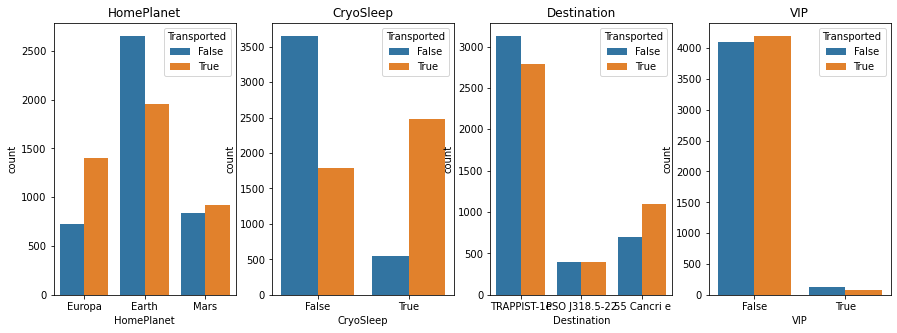

In [13]:
# visualize the observation number of each categorical features by count chart

# set the figure size
fig = plt.figure(figsize=(15,5))

for idx, val in enumerate(categorical_features):
    ax = fig.add_subplot(1,4,idx+1)
    sns.countplot(data=train, x=val, axes=ax, hue='Transported')
    ax.set_title(val)
    
plt.show()

We can find:
- The state of feature,'CryoSleep', shows obvious difference in Transported.
- 'VIP' does not provide useful information.


Insights:
- The feature 'VIP' could be droppred


### Qualitative features

In [14]:
qualitative_features = train[['PassengerId','Cabin','Name']]

qualitative_features.head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


We can find:
- first 4 number in 'PassengerId' is the group number, we may extract this number out as a new feature.
- 'Cabin' 


Insights:
- We can create new feature that indicates the group number
- We can create new feature that indicates the group size
